In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
1261/1261 [==============================] - 13s 9ms/step - loss: 0.6389 - val_loss: 0.6209
Epoch 2/10
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6149 - val_loss: 0.6185
Epoch 3/10
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6089 - val_loss: 0.6147
Epoch 4/10
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6074 - val_loss: 0.6106
Epoch 5/10
1261/1261 [==============================] - 15s 12ms/step - loss: 0.6064 - val_loss: 0.6130
Epoch 6/10
1261/1261 [==============================] - 13s 10ms/step - loss: 0.6062 - val_loss: 0.6098
Epoch 7/10
1261/1261 [==============================] - 12s 10ms/step - loss: 0.6051 - val_loss: 0.6121
Epoch 8/10
1261/1261 [==============================] - 11s 9ms/step - loss: 0.6048 - val_loss: 0.6125
Epoch 9/10
1261/1261 [==============================] - 14s 11ms/step - loss: 0.6048 - val_loss: 0.6113
Epoch 10/10
1261/1261 [==============================] - 12s 9ms/step

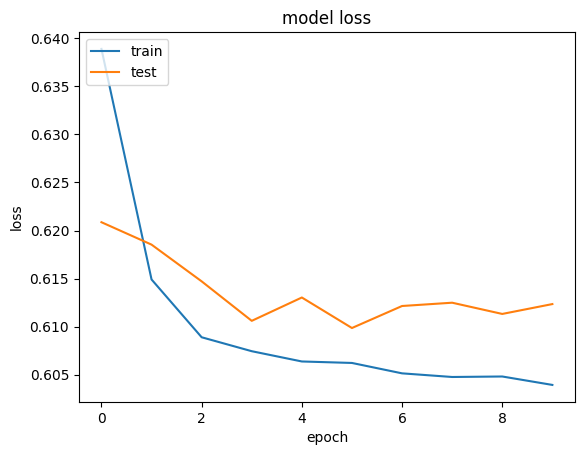

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv('/content/gdrive/MyDrive/ml-latest-small/movies.csv')

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

270/270 [==============================] - 1s 2ms/step
Showing recommendations for user: 606
Movies with high ratings from user
--------------------------------
My Fair Lady (1964) : Comedy|Drama|Musical|Romance
2001: A Space Odyssey (1968) : Adventure|Drama|Sci-Fi
Being John Malkovich (1999) : Comedy|Drama|Fantasy
Princess Mononoke (Mononoke-hime) (1997) : Action|Adventure|Animation|Drama|Fantasy
Guess Who's Coming to Dinner (1967) : Drama
--------------------------------
Top 10 movie recommendations
--------------------------------
Crumb (1994) : Documentary
Fargo (1996) : Comedy|Crime|Drama|Thriller
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Goodfellas (1990) : Crime|Drama
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Logan (2017) : Action|Sci-Fi
Three Billboards Out

In [ ]:
precision, recall, f_score = precision_recall_fmeasure(top_ratings, 3.5)
ndcg_measure = mdcg(top_ratings)
print("The precision is ", precision)
print("The recall is ", recall)
print("The f-score is ", f_score)
print("The NDCG value is ", ndcg_measure)

The precision is  0.94
The recall is  0.64
The f-score is  0.77
The NDCG value is  0.99
